# Setup Directories and Download Video

In [34]:
import os

if not os.path.exists('raw_videos'):
    os.mkdir('raw_videos')
    
if not os.path.exists('videos'):
    os.mkdir('videos')
    
if not os.path.exists('images'):
    os.mkdir('images')

In [ ]:
!cd raw_videos && pytube https://www.youtube.com/watch?v=PGMu_Z89Ao8

Loading video...
Driving Downtown - San Francisco 4K - USA.mp4 | 499 MB


In [28]:
import glob
import cv2
import time
import numpy as np
from imutils.video import FPS

video_path = glob.glob('raw_videos/*.mp4')[0]
output_video_path = 'videos/clip.mp4'
print (video_path)

raw_videos/Driving Downtown - San Francisco 4K - USA.mp4


# Clip Video

In [21]:
!ffmpeg -i "raw_videos/Driving Downtown - San Francisco 4K - USA.mp4" -t 00:01:00 -c:v copy "videos/clip.mp4"

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

# Load Trained Model

In [24]:
import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

In [35]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('./exportmodel_waymo_v120_efficientdet_d4/saved_model/')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 26.639695167541504s


In [36]:
from object_detection.utils import label_map_util

label_map_path='./waymo_labelmap.txt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

# Run Inference on Video Frames

In [37]:
cap = cv2.VideoCapture(output_video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

fps = FPS().start()
out = cv2.VideoWriter('./videos/output_video1.mp4', cv2.VideoWriter_fourcc('M','P','4','V'), 30, (frame_width,frame_height))

currentframe = 0
while (cap.isOpened() and currentframe<2000):
    ret, image_np = cap.read()
    if len((np.array(image_np)).shape) == 0:
        break
  
    input_tensor = np.expand_dims(image_np, 0)
    #start_time = time.time()
    detections = detect_fn(input_tensor)
    #end_time = time.time()
    #print(end_time - start_time)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)
    
    # save image every n frames
    if currentframe % 100 == 0:
        name = './images/frame' + str(currentframe) + '.jpg'
        cv2.imwrite(name, image_np_with_detections)
    
    currentframe += 1
    fps.update()
    out.write(image_np_with_detections)
    
fps.stop()
print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
cap.release()
out.release()

[INFO] elasped time: 258.66
[INFO] approx. FPS: 6.96


# Sample Image Output

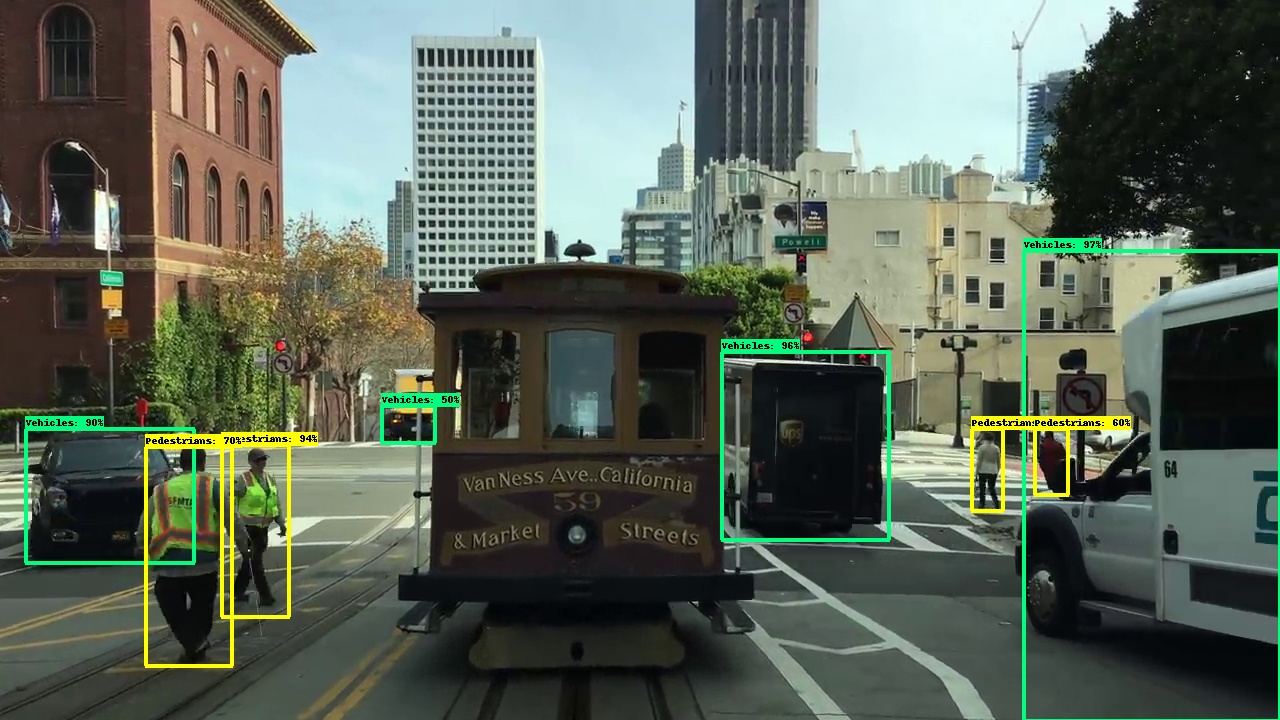

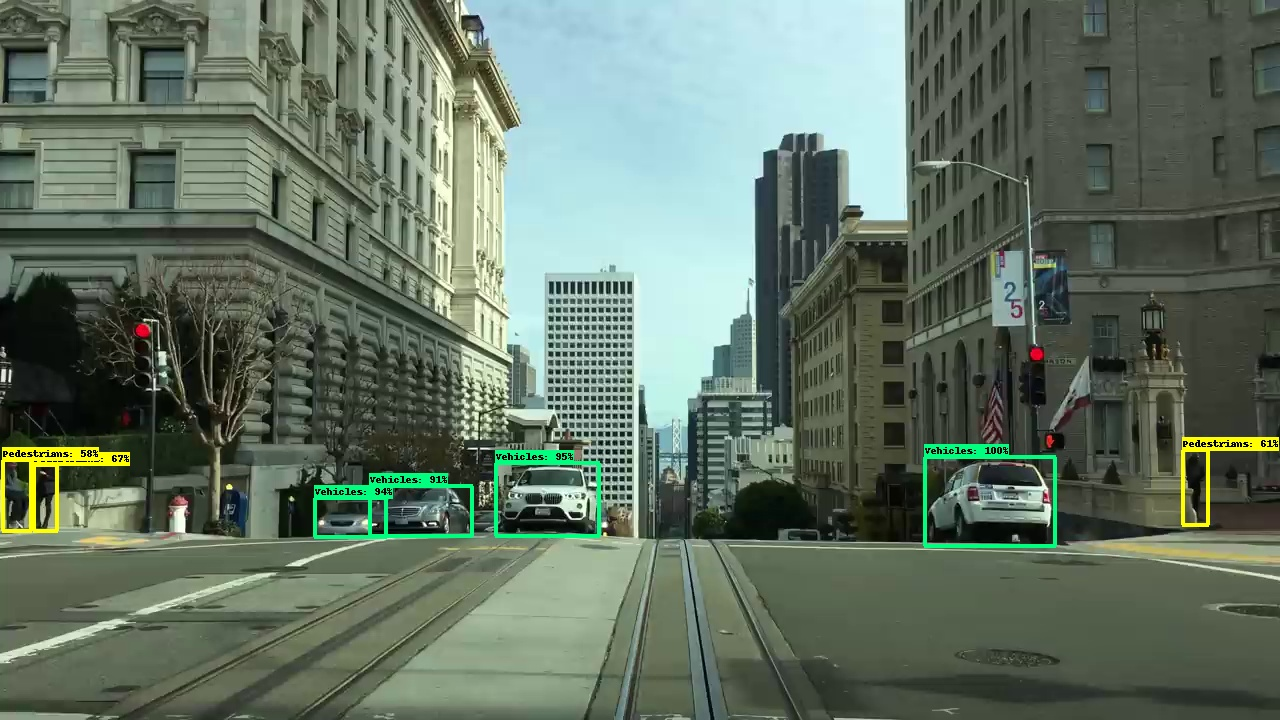

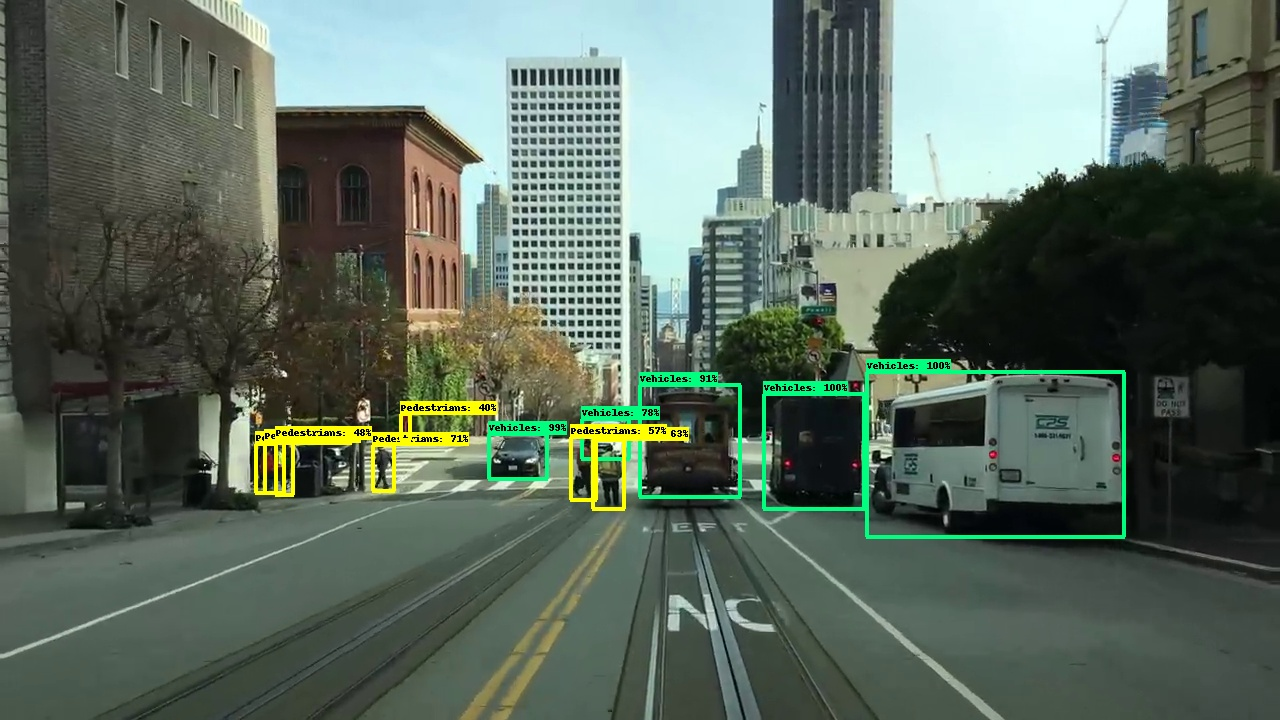

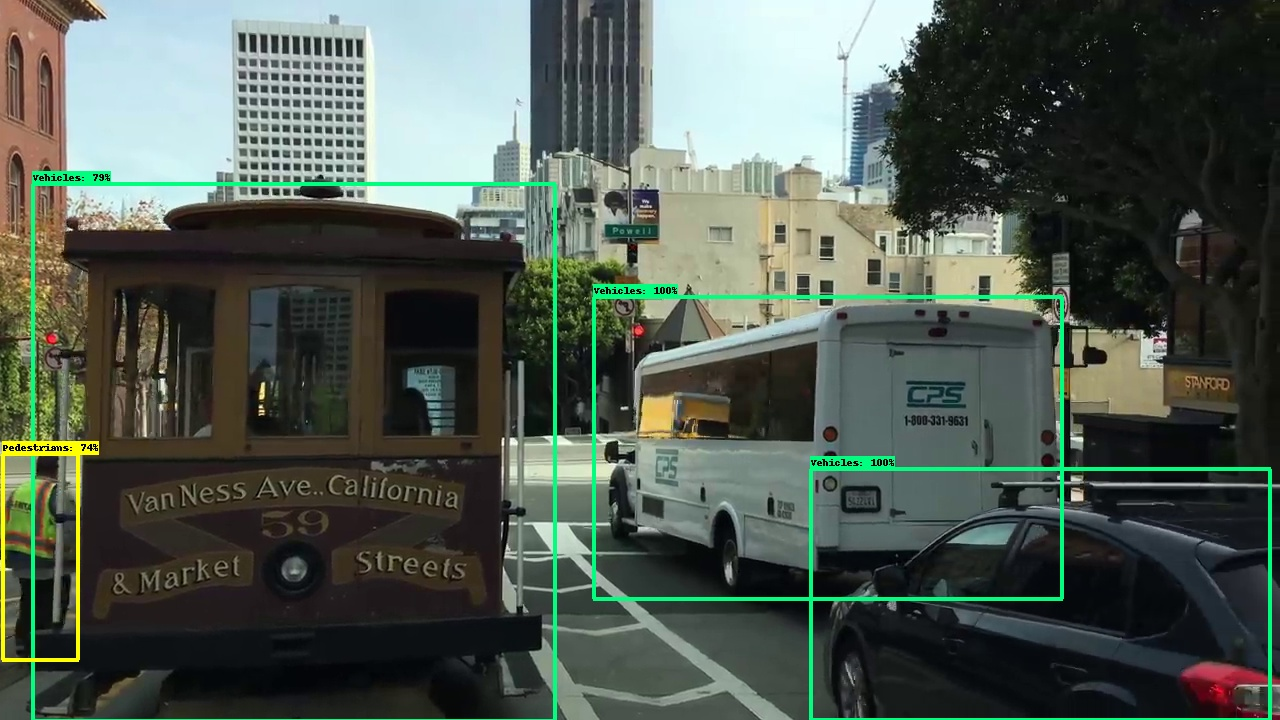

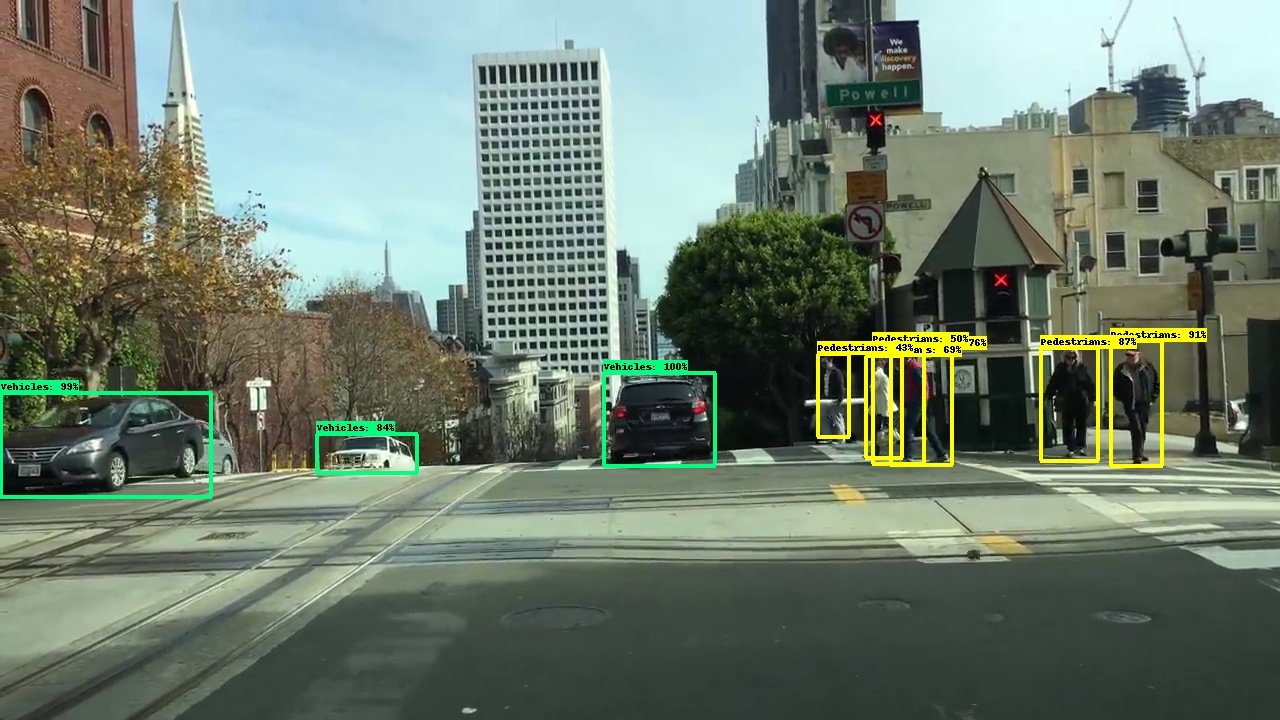

In [39]:
from IPython.display import Image, display

images = glob.glob('images/*.jpg')[:5]
for img in images:
    display(Image(filename=img) )